In [319]:
from scipy.sparse import load_npz
import matplotlib.pyplot as plt
import numpy as np
import sklearn.cluster
from collections import defaultdict, namedtuple, Counter
from os import listdir
from itertools import combinations
import json
import scipy.stats as stats

In [320]:
with open('../phased_spark_quads/chr.10.125500000.126500000.families.json', 'r') as f:
    families = json.load(f)
    
parental_variants = load_npz('../phased_spark_quads/chr.10.125500000.126500000.parental_variants.npz')

In [321]:
has_variant = parental_variants.T.dot(np.ones((parental_variants.shape[0],)))>0
has_variant_indices = has_variant.nonzero()[0] 
var_data = parental_variants[:, has_variant].A
print(var_data.shape)

(16664, 277)


In [322]:
families_to_remove = sorted(set([int(np.floor(x/4)) for x in np.where(np.all(var_data==0, axis=1))[0]]))
families = [x for i, x in enumerate(families) if i not in families_to_remove]
indices = np.ones((parental_variants.shape[0],), dtype=bool)
for i in families_to_remove:
    indices[(4*i):(4*(i+1))] = False
var_data = var_data[indices, :]
print(len(families)*4)
print(var_data.shape)

16636
(16636, 277)


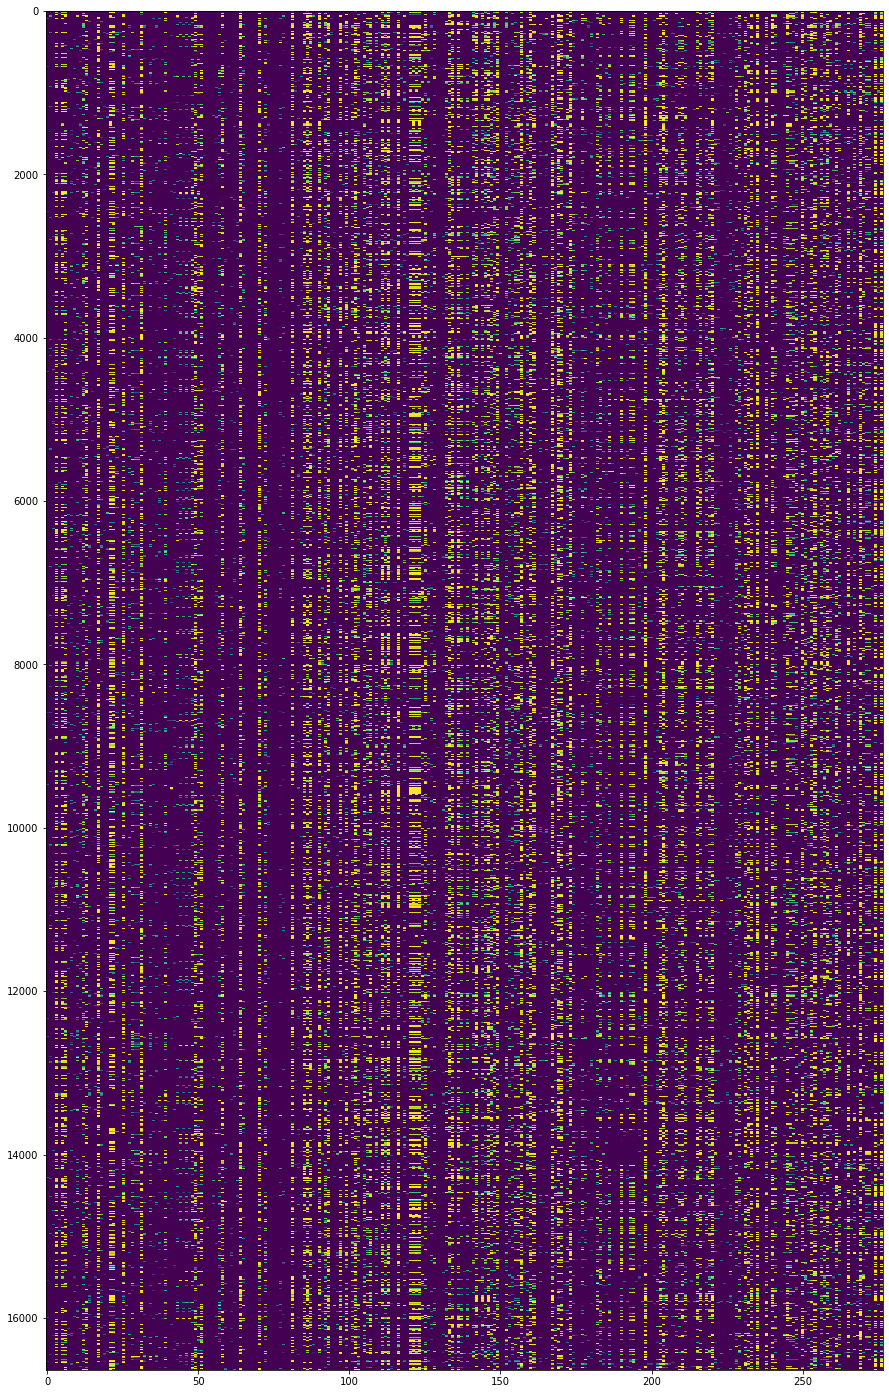

In [323]:
plt.figure(figsize=(15, 25))
plt.imshow(var_data, aspect='auto', vmin=0, vmax=1)
plt.show()

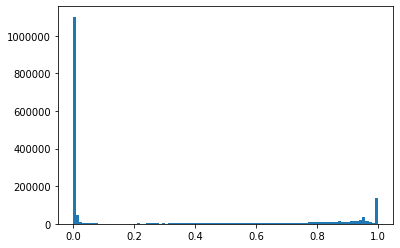

In [114]:
plt.hist(var_data.flatten()[var_data.flatten() != 0], bins=np.arange(0, 1.01, 0.01))
plt.show()

In [115]:
print(np.min(var_data), np.max(var_data))

0.0 0.9999999999999717


In [297]:
#clustering = sklearn.cluster.AgglomerativeClustering(affinity='cosine', linkage='complete',
#                                                     n_clusters=2).fit(var_data)

clustering = sklearn.cluster.DBSCAN(metric='cosine', eps=0.3, min_samples=50).fit((var_data>0.9).astype(int))



In [298]:
print(Counter(clustering.labels_))

Counter({-1: 14780, 0: 1733, 1: 67, 2: 56})


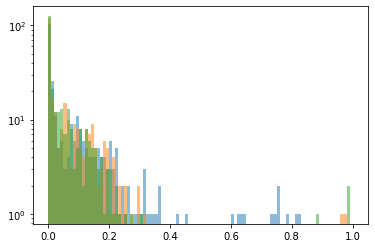

In [299]:
num_clusters = np.max(clustering.labels_)+1
cluster_centroids = np.zeros((num_clusters, var_data.shape[1]))
for i in range(num_clusters):
    cluster_centroids[i, :] = np.mean(var_data[clustering.labels_==i, :], axis=0)
    plt.hist(cluster_centroids[i, :], bins=np.arange(0, 1.01, 0.01), alpha=0.5, log=True)
plt.show()

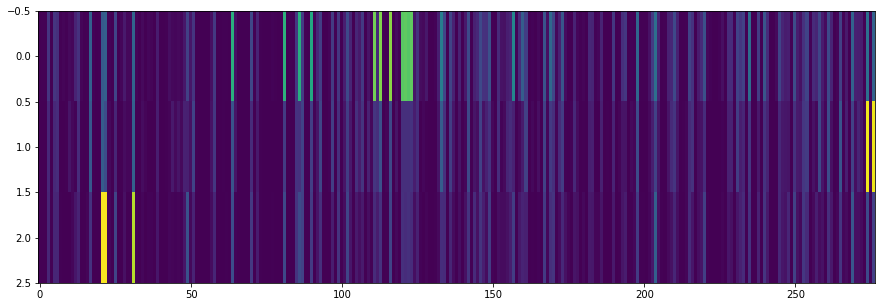

In [300]:
plt.figure(figsize=(15, 5))
plt.imshow(cluster_centroids, aspect='auto', vmin=0, vmax=1)
plt.show()

# Now do haplotype TDT

In [301]:
chrom = '10'
start_interval, end_interval = 125500000, 126500000

In [302]:
def pull_phenotype_ped(ped_file):
	sample_to_sex = dict()
	sample_to_affected = dict()
	with open(ped_file, 'r') as f:
		for line in f:
			pieces = line.strip().split('\t')
			sample_to_sex[pieces[1]] = pieces[4]
			sample_to_affected[pieces[1]] = pieces[5]
	return sample_to_affected, sample_to_sex

sample_to_affected, sample_to_sex = pull_phenotype_ped('../../DATA/spark/spark.ped.quads.ped')


In [303]:
# pull identicals
leave_out = set()
with open('../sibpair_similarity/spark_quads_identicals.txt', 'r') as f:
	for line in f:
		pieces = line.strip().split('\t')
		leave_out.update(pieces[1:])

In [304]:
phase_dir = '../phased_spark_quads'

# pull transmission matrix
# cluster, notrans/trans, unaff/aff, mat/pat
transmission = np.zeros((num_clusters, 2, 2, 2))
for family_index, family in enumerate(families):
    # figure out which cluster the parental haplotypes are in
    haplotypes = clustering.labels_[(4*family_index):(4*(family_index+1))]
    
    # figure out which parental copy is transmitted
    # child1/child2, 0/1/2/3
    trans_data = np.zeros((2, 4), dtype=int)
    print('%s/%s.phased.txt' % (phase_dir, family))
    with open('%s/%s.phased.txt' % (phase_dir, family), 'r')  as f:
        header = next(f).strip().split('\t')
        individuals = [header[i][:-4] for i in range(5, len(header)-3, 2)]
        
        if len(individuals)==4:
            for line in f:
                pieces = line.strip().split('\t')
                if pieces[0][3:] == chrom:
                    start_pos, end_pos = [int(x) for x in pieces[-2:]]
                    state = np.array([int(x) for x in pieces[1:-2]])

                    sib1_ind_index, sib2_ind_index = 2, 3
                    sib1_mat_index, sib2_mat_index = 4+2*sib1_ind_index, 4+2*sib2_ind_index
                    sib1_pat_index, sib2_pat_index = 5+2*sib1_ind_index, 5+2*sib2_ind_index

                    overlap = min(end_interval, end_pos) - max(start_interval, start_pos)
                    if overlap > 0:
                        if state[sib1_mat_index] != -1:
                            trans_data[0, int(state[sib1_mat_index])] += overlap
                        if state[sib1_pat_index] != -1:
                            trans_data[0, int(state[sib1_pat_index])] += overlap
                        if state[sib2_mat_index] != -1:
                            trans_data[1, int(state[sib2_mat_index])] += overlap
                        if state[sib2_pat_index] != -1:
                            trans_data[1, int(state[sib2_pat_index])] += overlap

            assert np.all(np.sum(trans_data[:, :2], axis=1) <= (end_interval-start_interval))
            assert np.all(np.sum(trans_data[:, 2:], axis=1) <= (end_interval-start_interval))

            # figure out child phenotypes
            aff = [int(sample_to_affected[x]=='2') for x in individuals[2:4]]

            opp_anc_index = {0:1, 1:0, 2:3, 3:2}

            # cluster, notrans/trans, unaff/aff
            for child_index in range(2):
                if individuals[2+child_index] not in leave_out:
                    for anc_index in range(4):
                        if trans_data[child_index, anc_index] >= 0.9*(end_interval-start_interval):
                            transmission[haplotypes[anc_index], 1, aff[child_index], int(anc_index<2)] += 1
                            transmission[haplotypes[opp_anc_index[anc_index]], 0, aff[child_index], int(anc_index<2)] += 1
                            
                    leave_out.add(individuals[2+child_index])
        

../phased_spark_quads/SF0000027.SP0000027.SP0000034.phased.txt
../phased_spark_quads/SF0000027.SP0000027.SP0000063.phased.txt
../phased_spark_quads/SF0000027.SP0000034.SP0000063.phased.txt
../phased_spark_quads/SF0000145.SP0001673.SP0000145.phased.txt
../phased_spark_quads/SF0000226.SP0000285.SP0000226.phased.txt
../phased_spark_quads/SF0000267.SP0001200.SP0000267.phased.txt
../phased_spark_quads/SF0000300.SP0000447.SP0000300.phased.txt
../phased_spark_quads/SF0000300.SP0000447.SP0000734.phased.txt
../phased_spark_quads/SF0000300.SP0000734.SP0000300.phased.txt
../phased_spark_quads/SF0000301.SP0000301.SP0000760.phased.txt
../phased_spark_quads/SF0000362.SP0000523.SP0000362.phased.txt
../phased_spark_quads/SF0000463.SP0000463.SP0000533.phased.txt
../phased_spark_quads/SF0000551.SP0001640.SP0000551.phased.txt
../phased_spark_quads/SF0000834.SP0000834.SP0001066.phased.txt
../phased_spark_quads/SF0000834.SP0000967.SP0000834.phased.txt
../phased_spark_quads/SF0000834.SP0000967.SP0001066.pha

../phased_spark_quads/SF0010366.SP0010436.SP0010366.phased.txt
../phased_spark_quads/SF0010366.SP0010436.SP0010467.phased.txt
../phased_spark_quads/SF0010366.SP0010489.SP0010366.phased.txt
../phased_spark_quads/SF0010366.SP0010489.SP0010436.phased.txt
../phased_spark_quads/SF0010366.SP0010489.SP0010467.phased.txt
../phased_spark_quads/SF0010399.SP0010459.SP0010399.phased.txt
../phased_spark_quads/SF0010523.SP0010559.SP0010523.phased.txt
../phased_spark_quads/SF0010543.SP0010543.SP0010641.phased.txt
../phased_spark_quads/SF0010587.SP0010587.SP0010658.phased.txt
../phased_spark_quads/SF0010593.SP0010593.SP0010661.phased.txt
../phased_spark_quads/SF0010618.SP0010618.SP0010686.phased.txt
../phased_spark_quads/SF0010628.SP0010628.SP0010731.phased.txt
../phased_spark_quads/SF0010673.SP0010673.SP0010738.phased.txt
../phased_spark_quads/SF0010751.SP0010786.SP0010751.phased.txt
../phased_spark_quads/SF0010754.SP0010754.SP0010789.phased.txt
../phased_spark_quads/SF0010762.SP0011028.SP0010762.pha

../phased_spark_quads/SF0016712.SP0016712.SP0016811.phased.txt
../phased_spark_quads/SF0016712.SP0016745.SP0016811.phased.txt
../phased_spark_quads/SF0016724.SP0016724.SP0016754.phased.txt
../phased_spark_quads/SF0016814.SP0016844.SP0016814.phased.txt
../phased_spark_quads/SF0016839.SP0016839.SP0016930.phased.txt
../phased_spark_quads/SF0016996.SP0016996.SP0017070.phased.txt
../phased_spark_quads/SF0017012.SP0017012.SP0017210.phased.txt
../phased_spark_quads/SF0017012.SP0017012.SP0017242.phased.txt
../phased_spark_quads/SF0017012.SP0017210.SP0017242.phased.txt
../phased_spark_quads/SF0017096.SP0017096.SP0017123.phased.txt
../phased_spark_quads/SF0017155.SP0017181.SP0017155.phased.txt
../phased_spark_quads/SF0017223.SP0017223.SP0017254.phased.txt
../phased_spark_quads/SF0017285.SP0017347.SP0017285.phased.txt
../phased_spark_quads/SF0017326.SP0017326.SP0017360.phased.txt
../phased_spark_quads/SF0017349.SP0017378.SP0017349.phased.txt
../phased_spark_quads/SF0017349.SP0017378.SP0017414.pha

../phased_spark_quads/SF0025050.SP0025050.SP0025070.phased.txt
../phased_spark_quads/SF0025073.SP0025073.SP0025074.phased.txt
../phased_spark_quads/SF0025098.SP0025098.SP0025115.phased.txt
../phased_spark_quads/SF0025116.SP0025116.SP0025130.phased.txt
../phased_spark_quads/SF0025145.SP0025153.SP0025145.phased.txt
../phased_spark_quads/SF0025229.SP0025229.SP0025257.phased.txt
../phased_spark_quads/SF0025241.SP0025241.SP0025296.phased.txt
../phased_spark_quads/SF0025241.SP0025241.SP0025320.phased.txt
../phased_spark_quads/SF0025241.SP0025320.SP0025296.phased.txt
../phased_spark_quads/SF0025250.SP0025323.SP0025250.phased.txt
../phased_spark_quads/SF0025270.SP0025270.SP0025328.phased.txt
../phased_spark_quads/SF0025278.SP0025278.SP0025372.phased.txt
../phased_spark_quads/SF0025396.SP0025423.SP0025396.phased.txt
../phased_spark_quads/SF0025436.SP0025436.SP0025500.phased.txt
../phased_spark_quads/SF0025453.SP0025453.SP0025482.phased.txt
../phased_spark_quads/SF0025466.SP0025466.SP0025619.pha

../phased_spark_quads/SF0032002.SP0032003.SP0032002.phased.txt
../phased_spark_quads/SF0032113.SP0032114.SP0032113.phased.txt
../phased_spark_quads/SF0032113.SP0032115.SP0032113.phased.txt
../phased_spark_quads/SF0032113.SP0032115.SP0032114.phased.txt
../phased_spark_quads/SF0032180.SP0032181.SP0032180.phased.txt
../phased_spark_quads/SF0032243.SP0032243.SP0032244.phased.txt
../phased_spark_quads/SF0032265.SP0032265.SP0032267.phased.txt
../phased_spark_quads/SF0032265.SP0032266.SP0032265.phased.txt
../phased_spark_quads/SF0032265.SP0032266.SP0032267.phased.txt
../phased_spark_quads/SF0032265.SP0032266.SP0032268.phased.txt
../phased_spark_quads/SF0032265.SP0032268.SP0032265.phased.txt
../phased_spark_quads/SF0032265.SP0032268.SP0032267.phased.txt
../phased_spark_quads/SF0032271.SP0032272.SP0032271.phased.txt
../phased_spark_quads/SF0032280.SP0032281.SP0032280.phased.txt
../phased_spark_quads/SF0032324.SP0032324.SP0032325.phased.txt
../phased_spark_quads/SF0032331.SP0032332.SP0032331.pha

../phased_spark_quads/SF0038003.SP0042157.SP0038003.phased.txt
../phased_spark_quads/SF0038003.SP0042157.SP0038004.phased.txt
../phased_spark_quads/SF0038010.SP0038010.SP0038011.phased.txt
../phased_spark_quads/SF0038083.SP0038083.SP0038084.phased.txt
../phased_spark_quads/SF0038090.SP0038090.SP0038091.phased.txt
../phased_spark_quads/SF0038212.SP0038213.SP0038212.phased.txt
../phased_spark_quads/SF0038219.SP0038219.SP0038222.phased.txt
../phased_spark_quads/SF0038233.SP0038233.SP0038234.phased.txt
../phased_spark_quads/SF0038233.SP0038233.SP0038235.phased.txt
../phased_spark_quads/SF0038233.SP0038234.SP0038235.phased.txt
../phased_spark_quads/SF0038253.SP0038253.SP0038254.phased.txt
../phased_spark_quads/SF0038315.SP0038316.SP0038315.phased.txt
../phased_spark_quads/SF0038330.SP0075872.SP0038330.phased.txt
../phased_spark_quads/SF0038363.SP0038363.SP0038364.phased.txt
../phased_spark_quads/SF0038399.SP0038401.SP0038399.phased.txt
../phased_spark_quads/SF0038407.SP0038408.SP0038407.pha

../phased_spark_quads/SF0045112.SP0045113.SP0045112.phased.txt
../phased_spark_quads/SF0045205.SP0045206.SP0045205.phased.txt
../phased_spark_quads/SF0045217.SP0045218.SP0045217.phased.txt
../phased_spark_quads/SF0045249.SP0045250.SP0045249.phased.txt
../phased_spark_quads/SF0045275.SP0045275.SP0045276.phased.txt
../phased_spark_quads/SF0045374.SP0045375.SP0045374.phased.txt
../phased_spark_quads/SF0045429.SP0045430.SP0045429.phased.txt
../phased_spark_quads/SF0045434.SP0045435.SP0045434.phased.txt
../phased_spark_quads/SF0045439.SP0045439.SP0045440.phased.txt
../phased_spark_quads/SF0045451.SP0045451.SP0045452.phased.txt
../phased_spark_quads/SF0045504.SP0045505.SP0045504.phased.txt
../phased_spark_quads/SF0045525.SP0045525.SP0045526.phased.txt
../phased_spark_quads/SF0045550.SP0045551.SP0045550.phased.txt
../phased_spark_quads/SF0045564.SP0045566.SP0045564.phased.txt
../phased_spark_quads/SF0045593.SP0045593.SP0045594.phased.txt
../phased_spark_quads/SF0045619.SP0045619.SP0045620.pha

../phased_spark_quads/SF0052491.SP0052491.SP0052492.phased.txt
../phased_spark_quads/SF0052616.SP0052616.SP0052617.phased.txt
../phased_spark_quads/SF0052624.SP0052624.SP0052627.phased.txt
../phased_spark_quads/SF0052654.SP0052654.SP0052656.phased.txt
../phased_spark_quads/SF0052655.SP0052657.SP0052655.phased.txt
../phased_spark_quads/SF0052676.SP0052676.SP0052677.phased.txt
../phased_spark_quads/SF0052719.SP0052719.SP0052720.phased.txt
../phased_spark_quads/SF0052758.SP0052758.SP0052759.phased.txt
../phased_spark_quads/SF0052766.SP0052767.SP0052766.phased.txt
../phased_spark_quads/SF0052828.SP0052829.SP0052828.phased.txt
../phased_spark_quads/SF0052849.SP0052850.SP0052849.phased.txt
../phased_spark_quads/SF0052880.SP0052880.SP0052881.phased.txt
../phased_spark_quads/SF0052918.SP0052918.SP0052919.phased.txt
../phased_spark_quads/SF0052929.SP0052930.SP0052929.phased.txt
../phased_spark_quads/SF0052969.SP0052969.SP0052970.phased.txt
../phased_spark_quads/SF0052988.SP0052988.SP0052990.pha

../phased_spark_quads/SF0060385.SP0060385.SP0060386.phased.txt
../phased_spark_quads/SF0060414.SP0060414.SP0060415.phased.txt
../phased_spark_quads/SF0060424.SP0060424.SP0060426.phased.txt
../phased_spark_quads/SF0060516.SP0060517.SP0060516.phased.txt
../phased_spark_quads/SF0060524.SP0060525.SP0060524.phased.txt
../phased_spark_quads/SF0060538.SP0060538.SP0060539.phased.txt
../phased_spark_quads/SF0060543.SP0060543.SP0060544.phased.txt
../phased_spark_quads/SF0060580.SP0060580.SP0060581.phased.txt
../phased_spark_quads/SF0060627.SP0060627.SP0060628.phased.txt
../phased_spark_quads/SF0060689.SP0060689.SP0060690.phased.txt
../phased_spark_quads/SF0060689.SP0060689.SP0060691.phased.txt
../phased_spark_quads/SF0060689.SP0060691.SP0060690.phased.txt
../phased_spark_quads/SF0060727.SP0060728.SP0060727.phased.txt
../phased_spark_quads/SF0060743.SP0060743.SP0060745.phased.txt
../phased_spark_quads/SF0060807.SP0060807.SP0060809.phased.txt
../phased_spark_quads/SF0060820.SP0060820.SP0060821.pha

../phased_spark_quads/SF0067552.SP0067554.SP0067552.phased.txt
../phased_spark_quads/SF0067705.SP0067705.SP0067706.phased.txt
../phased_spark_quads/SF0067736.SP0067737.SP0067736.phased.txt
../phased_spark_quads/SF0067763.SP0067764.SP0067763.phased.txt
../phased_spark_quads/SF0067811.SP0067811.SP0067812.phased.txt
../phased_spark_quads/SF0067840.SP0067840.SP0067841.phased.txt
../phased_spark_quads/SF0067852.SP0067852.SP0067853.phased.txt
../phased_spark_quads/SF0067896.SP0067896.SP0067897.phased.txt
../phased_spark_quads/SF0068063.SP0068063.SP0068064.phased.txt
../phased_spark_quads/SF0068108.SP0068109.SP0068108.phased.txt
../phased_spark_quads/SF0068235.SP0068236.SP0068235.phased.txt
../phased_spark_quads/SF0068298.SP0068298.SP0068299.phased.txt
../phased_spark_quads/SF0068363.SP0068363.SP0068364.phased.txt
../phased_spark_quads/SF0068380.SP0068380.SP0068381.phased.txt
../phased_spark_quads/SF0068385.SP0068386.SP0068385.phased.txt
../phased_spark_quads/SF0068433.SP0068433.SP0068434.pha

../phased_spark_quads/SF0075404.SP0075405.SP0075404.phased.txt
../phased_spark_quads/SF0075524.SP0075525.SP0075524.phased.txt
../phased_spark_quads/SF0075560.SP0075561.SP0075560.phased.txt
../phased_spark_quads/SF0075577.SP0075578.SP0075577.phased.txt
../phased_spark_quads/SF0075587.SP0075588.SP0075587.phased.txt
../phased_spark_quads/SF0075626.SP0075627.SP0075626.phased.txt
../phased_spark_quads/SF0075642.SP0075643.SP0075642.phased.txt
../phased_spark_quads/SF0075680.SP0075681.SP0075680.phased.txt
../phased_spark_quads/SF0075683.SP0075683.SP0075684.phased.txt
../phased_spark_quads/SF0075687.SP0075697.SP0075687.phased.txt
../phased_spark_quads/SF0075689.SP0075689.SP0075690.phased.txt
../phased_spark_quads/SF0075720.SP0075720.SP0075721.phased.txt
../phased_spark_quads/SF0075777.SP0075777.SP0075778.phased.txt
../phased_spark_quads/SF0075795.SP0075795.SP0075796.phased.txt
../phased_spark_quads/SF0075795.SP0075795.SP0075797.phased.txt
../phased_spark_quads/SF0075795.SP0075797.SP0075796.pha

../phased_spark_quads/SF0082999.SP0083000.SP0082999.phased.txt
../phased_spark_quads/SF0083020.SP0083020.SP0083025.phased.txt
../phased_spark_quads/SF0083027.SP0083027.SP0083029.phased.txt
../phased_spark_quads/SF0083085.SP0083086.SP0083085.phased.txt
../phased_spark_quads/SF0083096.SP0083097.SP0083096.phased.txt
../phased_spark_quads/SF0083101.SP0083101.SP0083102.phased.txt
../phased_spark_quads/SF0083107.SP0083108.SP0083107.phased.txt
../phased_spark_quads/SF0083114.SP0083114.SP0083115.phased.txt
../phased_spark_quads/SF0083114.SP0083114.SP0083121.phased.txt
../phased_spark_quads/SF0083114.SP0083121.SP0083115.phased.txt
../phased_spark_quads/SF0083143.SP0083144.SP0083143.phased.txt
../phased_spark_quads/SF0083238.SP0083239.SP0083238.phased.txt
../phased_spark_quads/SF0083288.SP0083288.SP0083289.phased.txt
../phased_spark_quads/SF0083333.SP0083334.SP0083333.phased.txt
../phased_spark_quads/SF0083440.SP0083440.SP0083441.phased.txt
../phased_spark_quads/SF0083528.SP0083529.SP0083528.pha

../phased_spark_quads/SF0091822.SP0091822.SP0091823.phased.txt
../phased_spark_quads/SF0091822.SP0091822.SP0091825.phased.txt
../phased_spark_quads/SF0091822.SP0091822.SP0091827.phased.txt
../phased_spark_quads/SF0091822.SP0091824.SP0091822.phased.txt
../phased_spark_quads/SF0091822.SP0091824.SP0091823.phased.txt
../phased_spark_quads/SF0091822.SP0091824.SP0091825.phased.txt
../phased_spark_quads/SF0091822.SP0091824.SP0091827.phased.txt
../phased_spark_quads/SF0091822.SP0091825.SP0091823.phased.txt
../phased_spark_quads/SF0091822.SP0091825.SP0091827.phased.txt
../phased_spark_quads/SF0091822.SP0091826.SP0091822.phased.txt
../phased_spark_quads/SF0091822.SP0091826.SP0091823.phased.txt
../phased_spark_quads/SF0091822.SP0091826.SP0091824.phased.txt
../phased_spark_quads/SF0091822.SP0091826.SP0091825.phased.txt
../phased_spark_quads/SF0091822.SP0091826.SP0091827.phased.txt
../phased_spark_quads/SF0091822.SP0091827.SP0091823.phased.txt
../phased_spark_quads/SF0091837.SP0091837.SP0091838.pha

../phased_spark_quads/SF0099898.SP0099898.SP0099907.phased.txt
../phased_spark_quads/SF0099950.SP0099951.SP0099950.phased.txt
../phased_spark_quads/SF0100062.SP0100064.SP0100062.phased.txt
../phased_spark_quads/SF0100115.SP0100117.SP0100115.phased.txt
../phased_spark_quads/SF0100138.SP0100139.SP0100138.phased.txt
../phased_spark_quads/SF0100281.SP0100281.SP0100283.phased.txt
../phased_spark_quads/SF0100281.SP0100286.SP0100281.phased.txt
../phased_spark_quads/SF0100281.SP0100286.SP0100283.phased.txt
../phased_spark_quads/SF0100281.SP0100287.SP0100281.phased.txt
../phased_spark_quads/SF0100281.SP0100287.SP0100283.phased.txt
../phased_spark_quads/SF0100281.SP0100287.SP0100286.phased.txt
../phased_spark_quads/SF0100364.SP0100365.SP0100364.phased.txt
../phased_spark_quads/SF0100364.SP0100365.SP0100368.phased.txt
../phased_spark_quads/SF0100364.SP0100367.SP0100364.phased.txt
../phased_spark_quads/SF0100364.SP0100367.SP0100365.phased.txt
../phased_spark_quads/SF0100364.SP0100367.SP0100368.pha

../phased_spark_quads/SF0112467.SP0112467.SP0112468.phased.txt
../phased_spark_quads/SF0112493.SP0112493.SP0112494.phased.txt
../phased_spark_quads/SF0112522.SP0112522.SP0112523.phased.txt
../phased_spark_quads/SF0112551.SP0112551.SP0112552.phased.txt
../phased_spark_quads/SF0112574.SP0112575.SP0112574.phased.txt
../phased_spark_quads/SF0112585.SP0112585.SP0112586.phased.txt
../phased_spark_quads/SF0112662.SP0112665.SP0112662.phased.txt
../phased_spark_quads/SF0112670.SP0112670.SP0112671.phased.txt
../phased_spark_quads/SF0112670.SP0112672.SP0112670.phased.txt
../phased_spark_quads/SF0112670.SP0112672.SP0112671.phased.txt
../phased_spark_quads/SF0112807.SP0112807.SP0112808.phased.txt
../phased_spark_quads/SF0112847.SP0112847.SP0112848.phased.txt
../phased_spark_quads/SF0112915.SP0112916.SP0112915.phased.txt
../phased_spark_quads/SF0112989.SP0112990.SP0112989.phased.txt
../phased_spark_quads/SF0113060.SP0113062.SP0113060.phased.txt
../phased_spark_quads/SF0113261.SP0113263.SP0113261.pha

../phased_spark_quads/SF0126635.SP0126637.SP0126635.phased.txt
../phased_spark_quads/SF0126636.SP0126636.SP0126638.phased.txt
../phased_spark_quads/SF0126686.SP0126688.SP0126686.phased.txt
../phased_spark_quads/SF0126692.SP0126692.SP0126693.phased.txt
../phased_spark_quads/SF0126749.SP0126750.SP0126749.phased.txt
../phased_spark_quads/SF0126771.SP0126772.SP0126771.phased.txt
../phased_spark_quads/SF0126771.SP0126772.SP0126775.phased.txt
../phased_spark_quads/SF0126771.SP0126775.SP0126771.phased.txt
../phased_spark_quads/SF0126805.SP0126805.SP0126807.phased.txt
../phased_spark_quads/SF0126876.SP0126876.SP0126877.phased.txt
../phased_spark_quads/SF0126886.SP0126886.SP0126887.phased.txt
../phased_spark_quads/SF0126895.SP0126896.SP0126895.phased.txt
../phased_spark_quads/SF0126961.SP0126962.SP0126961.phased.txt
../phased_spark_quads/SF0127097.SP0127098.SP0127097.phased.txt
../phased_spark_quads/SF0127237.SP0127238.SP0127237.phased.txt
../phased_spark_quads/SF0127237.SP0127239.SP0127237.pha

../phased_spark_quads/SF0140723.SP0140723.SP0144691.phased.txt
../phased_spark_quads/SF0140738.SP0140738.SP0140739.phased.txt
../phased_spark_quads/SF0140787.SP0140788.SP0140787.phased.txt
../phased_spark_quads/SF0140792.SP0140793.SP0140792.phased.txt
../phased_spark_quads/SF0140803.SP0140804.SP0140803.phased.txt
../phased_spark_quads/SF0140821.SP0140822.SP0140821.phased.txt
../phased_spark_quads/SF0140826.SP0140827.SP0140826.phased.txt
../phased_spark_quads/SF0141034.SP0141034.SP0141035.phased.txt
../phased_spark_quads/SF0141107.SP0141108.SP0141107.phased.txt
../phased_spark_quads/SF0141107.SP0141108.SP0141109.phased.txt
../phased_spark_quads/SF0141107.SP0141109.SP0141107.phased.txt
../phased_spark_quads/SF0141149.SP0141150.SP0141149.phased.txt
../phased_spark_quads/SF0141417.SP0141417.SP0141418.phased.txt
../phased_spark_quads/SF0141439.SP0141439.SP0141441.phased.txt
../phased_spark_quads/SF0141469.SP0141469.SP0141470.phased.txt
../phased_spark_quads/SF0141509.SP0141509.SP0141510.pha

In [305]:
for i in range(num_clusters):
    try:
        print(i, 'n=', np.sum(clustering.labels_==i))
        #print('maternal')
        #print(transmission[i, :, :, 0])
        #print('unaff', stats.binom_test(transmission[i, :, 0, 0]))
        #print('aff', stats.binom_test(transmission[i, :, 1, 0]))
        #print('chi2', stats.chi2_contingency(transmission[i, :, :, 0])[1])
        #print('paternal')
        #print(transmission[i, :, :, 1])
        #print('unaff', stats.binom_test(transmission[i, :, 0, 1]))
        #print('aff', stats.binom_test(transmission[i, :, 1, 1]))
        #print('chi2', stats.chi2_contingency(transmission[i, :, :, 1])[1])
        #print('both')
        print(np.sum(transmission[i, :, :, :], axis=2))
        print('unaff', stats.binom_test(np.sum(transmission[i, :, 0, :], axis=1)))
        print('aff', stats.binom_test(np.sum(transmission[i, :, 1, :], axis=1)))
        print('chi2', stats.chi2_contingency(np.sum(transmission[i, :, :, :], axis=2))[1])
        print()
    except:
        pass

0 n= 1733
[[475. 651.]
 [651. 838.]]
unaff 1.7380206074783786e-07
aff 1.3913611752917912e-06
chi2 0.45595031813023157

1 n= 67
[[20. 21.]
 [26. 32.]]
unaff 0.4613911821367656
aff 0.16897782228771882
chi2 0.854100839517232

2 n= 56
[[5153. 6854.]
 [4971. 6656.]]
unaff 0.07203222105770336
aff 0.0900947712495397
chi2 0.810680872513033



In [315]:
print(np.log10(71702*2/3))

4.6794400106546545
